In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import os
import math
import librosa
import random
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

plt.style.use('default')

In [2]:
def load_wav(filename):
    file_content = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    wav = tf.squeeze(wav, axis=1)
    sample_rate = tf.cast(sample_rate, tf.int64)
    return tfio.audio.resample(wav, rate_in=sample_rate, rate_out=32_000)


def preprocess(file_path):
    wav = load_wav(file_path)
    # wav = wav[:96_000]
    # zero_padding = tf.zeros([96_000] - tf.shape(wav), dtype=tf.float32)
    # wav = tf.concat([zero_padding, wav], 0)
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    spectogram = tf.tile(spectogram, [1, 1, 3])
    # spectogram = tf.image.resize(spectogram, [2991, 257])
    return spectogram


def preprocess2(file_path):
    wav = load_wav(file_path)
    wav = wav[:96_000]
    zero_padding = tf.zeros([96_000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)

    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    magnitude = tf.abs(spectogram)

    num_spectogram_bins = magnitude.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000.0, 128
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectogram_bins, 32000, lower_edge_hertz, upper_edge_hertz
    )
    mel_spectogram = tf.tensordot(magnitude, linear_to_mel_weight_matrix, 1)
    mel_spectogram.set_shape(magnitude.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    log_mel_spectogram = tf.math.log(mel_spectogram + 1e-6)

    return log_mel_spectogram

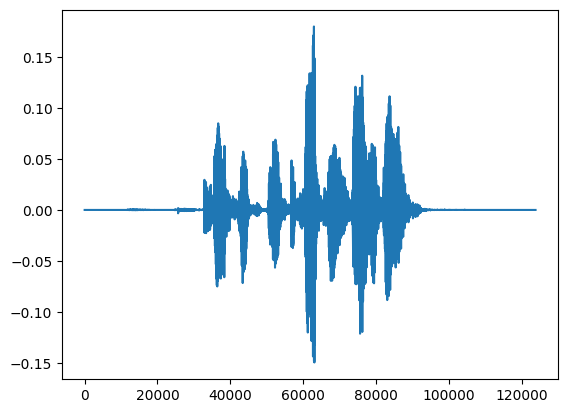

In [3]:
dummy = r"data/audio/angry/03-01-05-01-01-01-01.wav"
dummy = load_wav(dummy)
plt.plot(dummy)
plt.show()

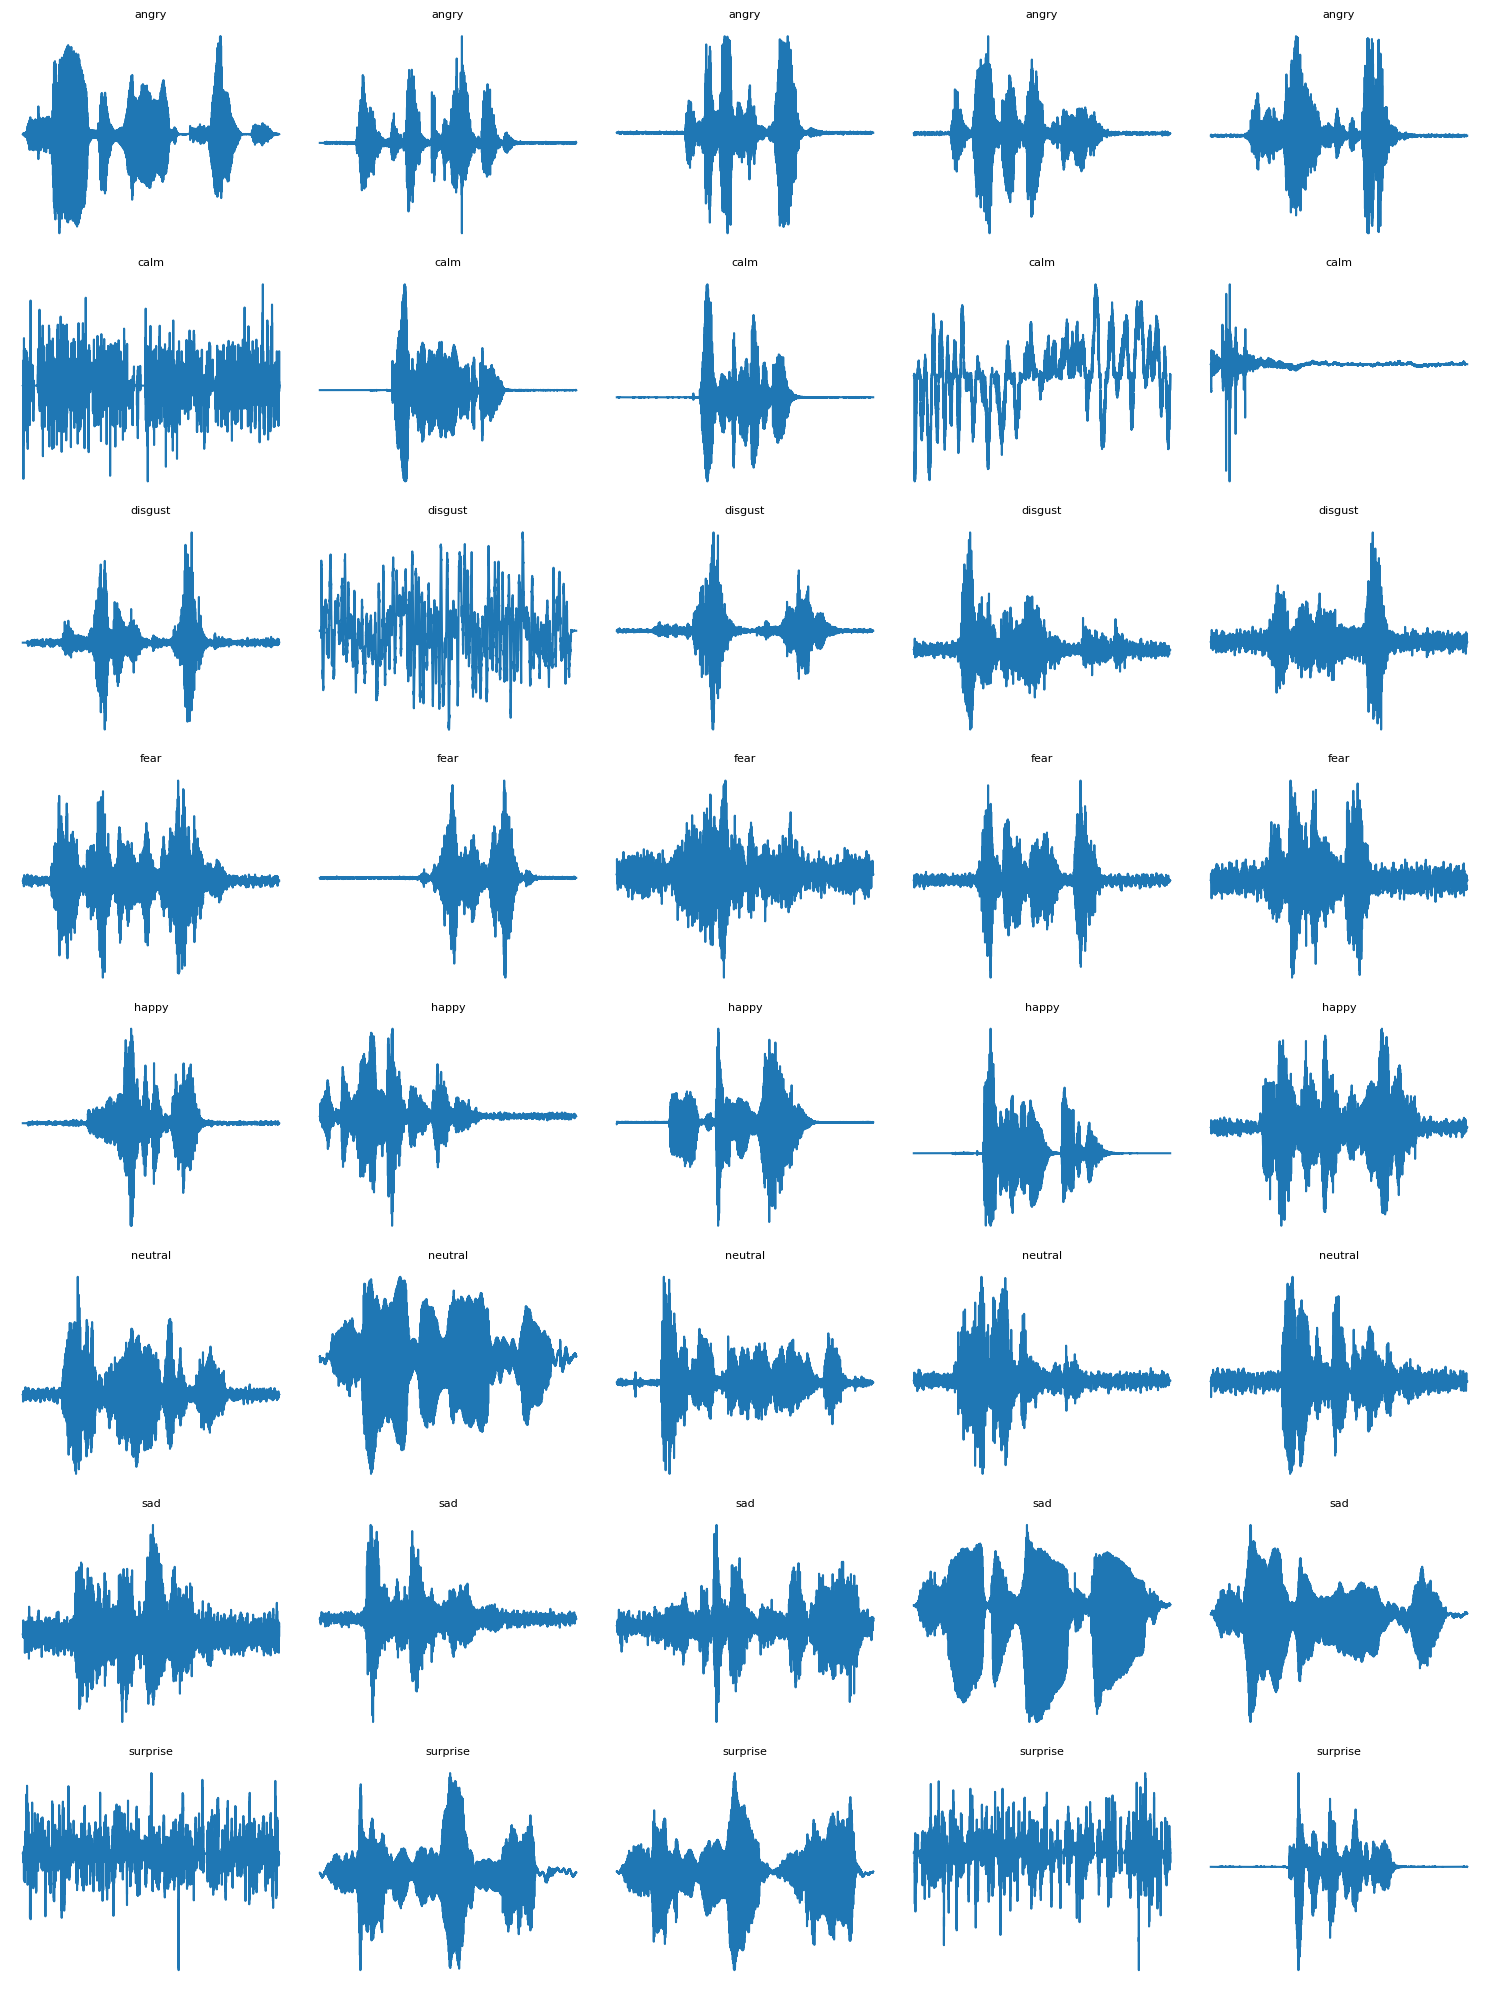

In [4]:
base_path = "data/audio"
emotion_classes = sorted(os.listdir(base_path))

num_per_class = 5
plt.figure(figsize=(num_per_class * 3, len(emotion_classes) * 2.5))

plot_index = 1
for emotion_idx, emotion in enumerate(emotion_classes):
    emotion_path = os.path.join(base_path, emotion)
    files = [f for f in os.listdir(emotion_path) if f.endswith(".wav")]
    if len(files) < num_per_class:
        continue

    selected_files = random.sample(files, num_per_class)

    for j, filename in enumerate(selected_files):
        file_path = os.path.join(emotion_path, filename)
        waveform = load_wav(file_path).numpy()

        plt.subplot(len(emotion_classes), num_per_class, plot_index)
        plt.plot(waveform)
        plt.title(f"{emotion}", fontsize=8)
        plt.axis("off")
        plot_index += 1

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.1812963].


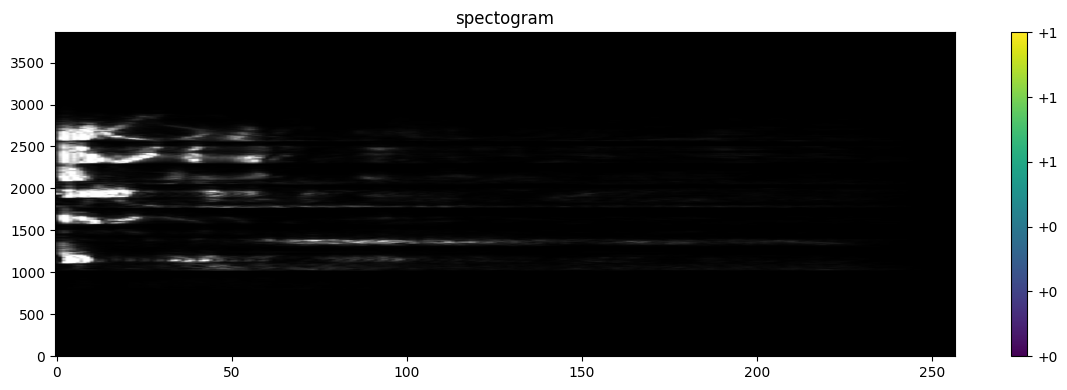

In [6]:
spectogram = preprocess('data/audio/angry/03-01-05-01-01-01-01.wav')

spectogram_np = spectogram.numpy()

# Plotting
plt.figure(figsize=(12, 4))
plt.imshow(spectogram_np, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f')
plt.title('spectogram')
plt.tight_layout()
plt.show()


In [8]:
spectogram_np.shape

(3861, 257, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.1812963].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.169767].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6184226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.8663952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.1674404].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6153209].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9091389].
Clipping input data to the valid ra

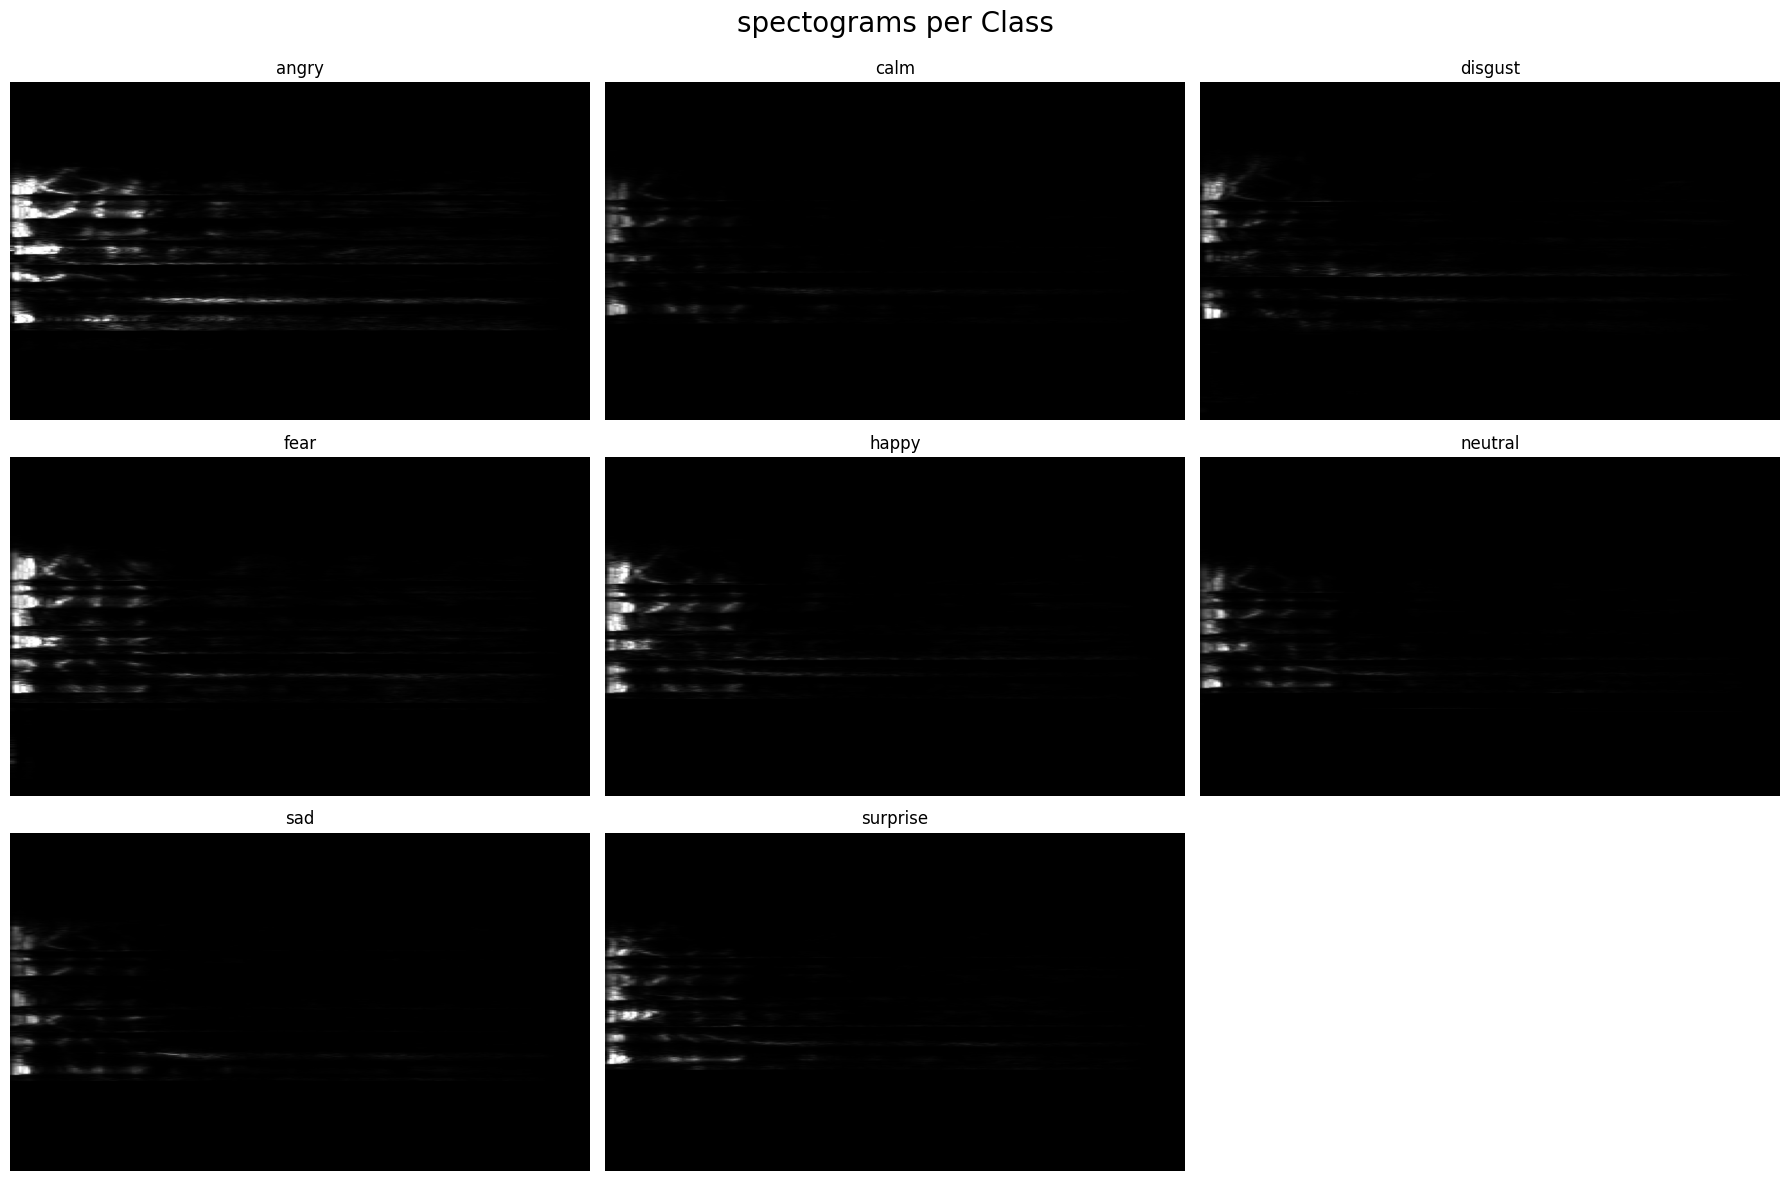

In [10]:
base_path = 'data/audio'
emotion_classes = sorted(os.listdir(base_path))

# Plot setup
plt.figure(figsize=(18, 12))

for i, emotion in enumerate(emotion_classes):
    emotion_path = os.path.join(base_path, emotion)
    wav_files = [f for f in os.listdir(emotion_path) if f.endswith('.wav')]
    if not wav_files:
        continue

    # Preprocess one file per class
    file_path = os.path.join(emotion_path, wav_files[0])
    spectogram = preprocess(file_path)
    spectogram_np = spectogram.numpy()

    # Plot spectogram
    plt.subplot(3, 3, i + 1)
    plt.imshow(spectogram_np, aspect='auto', origin='lower')
    plt.title(emotion)
    plt.axis('off')

plt.suptitle('spectograms per Class', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


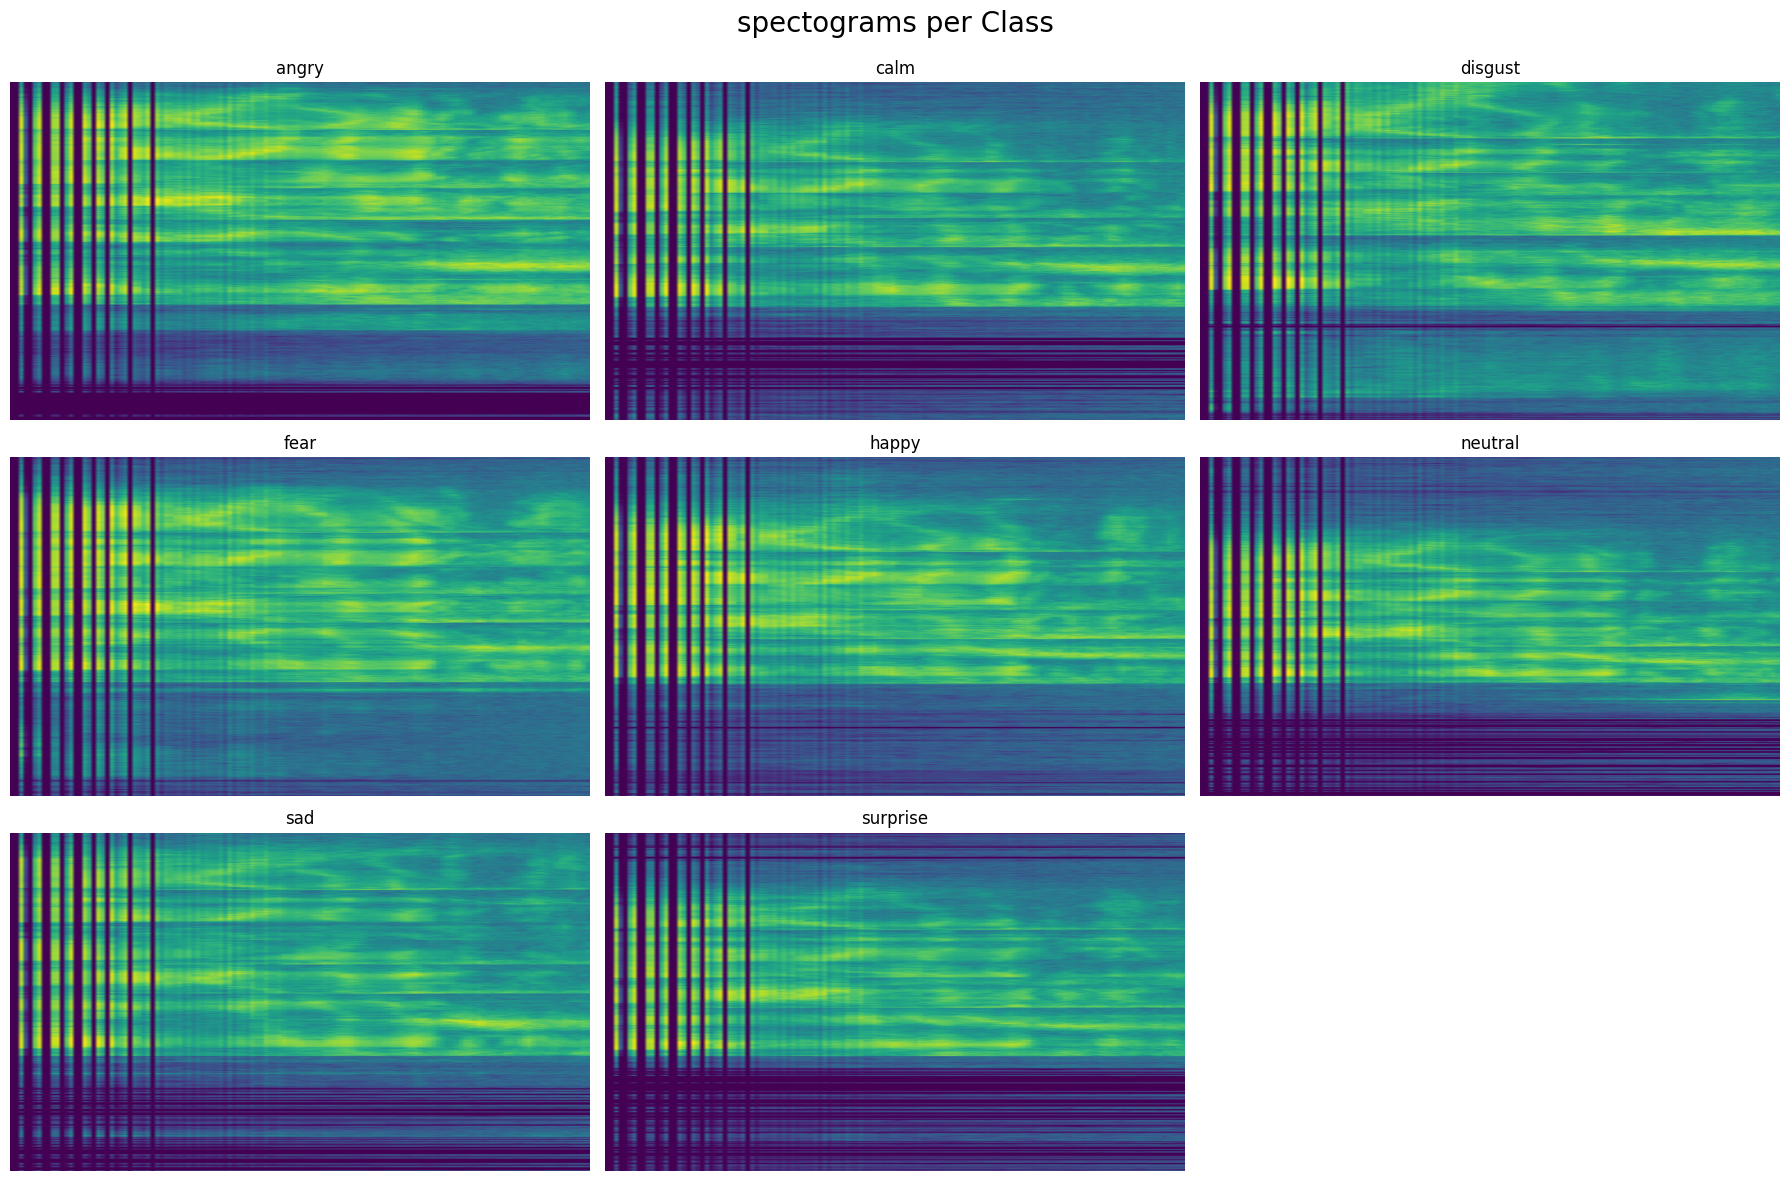

In [11]:
base_path = 'data/audio'
emotion_classes = sorted(os.listdir(base_path))

# Plot setup
plt.figure(figsize=(18, 12))

for i, emotion in enumerate(emotion_classes):
    emotion_path = os.path.join(base_path, emotion)
    wav_files = [f for f in os.listdir(emotion_path) if f.endswith('.wav')]
    if not wav_files:
        continue

    # Preprocess one file per class
    file_path = os.path.join(emotion_path, wav_files[0])
    spectogram = preprocess2(file_path)
    spectogram_np = spectogram.numpy()

    # Plot spectogram
    plt.subplot(3, 3, i + 1)
    plt.imshow(spectogram_np, aspect='auto', origin='lower')
    plt.title(emotion)
    plt.axis('off')

plt.suptitle('spectograms per Class', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [12]:
spectogram_np.shape

(2991, 128)

In [13]:
def load_audio(file_content, target_sr):
    audio, sample_rate = librosa.load(file_content, sr=target_sr, mono=True)
    trim, _ = librosa.effects.trim(audio, top_db=20)
    wav_resampled = librosa.resample(trim, orig_sr=sample_rate, target_sr=target_sr)
    return wav_resampled, target_sr


def preprocess_librosa(file_content, target_sr=32000, n_fft=320, hop_length=32, n_mels=128, fmin=80.0, fmax=7600.0):
    audio, sample_rate = load_audio(file_content, target_sr)
    # target_samples = int(np.ceil(len(audio) / sample_rate) * target_sr)
    # if len(audio) < target_samples:
    #     audio = np.pad(audio, (0, target_samples - len(audio)), mode='constant')

    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio,
        sr=target_sr,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax
    )
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.min)
    spectogram = np.expand_dims(mel_spectrogram_db, axis=-1)
    spectogram = np.repeat(spectogram, 3, axis=-1)
    return spectogram

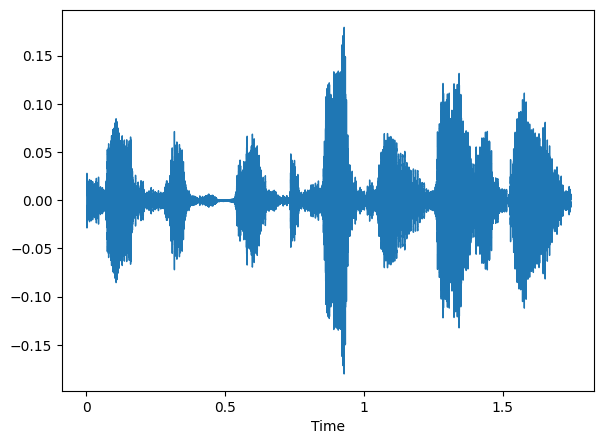

In [14]:
dummy = r"data/audio/angry/03-01-05-01-01-01-01.wav"
dummy, sr = load_audio(dummy, 32_000)
librosa.display.waveshow(dummy, sr=sr)
plt.tight_layout(pad=2)
plt.show()

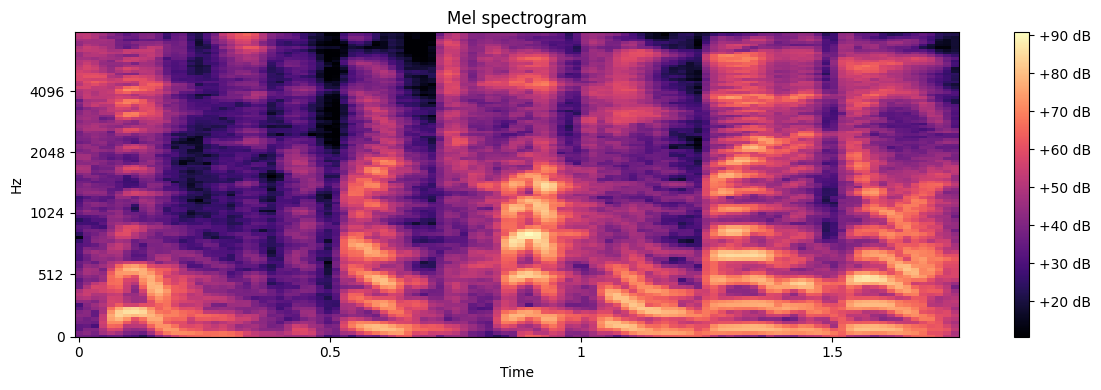

In [16]:
spectogram = preprocess_librosa(r"data/audio/angry/03-01-05-01-01-01-01.wav")

plt.figure(figsize=(12, 4))
librosa.display.specshow(spectogram[:, :, 0], sr=32000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.ylim(0, 8000)
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()


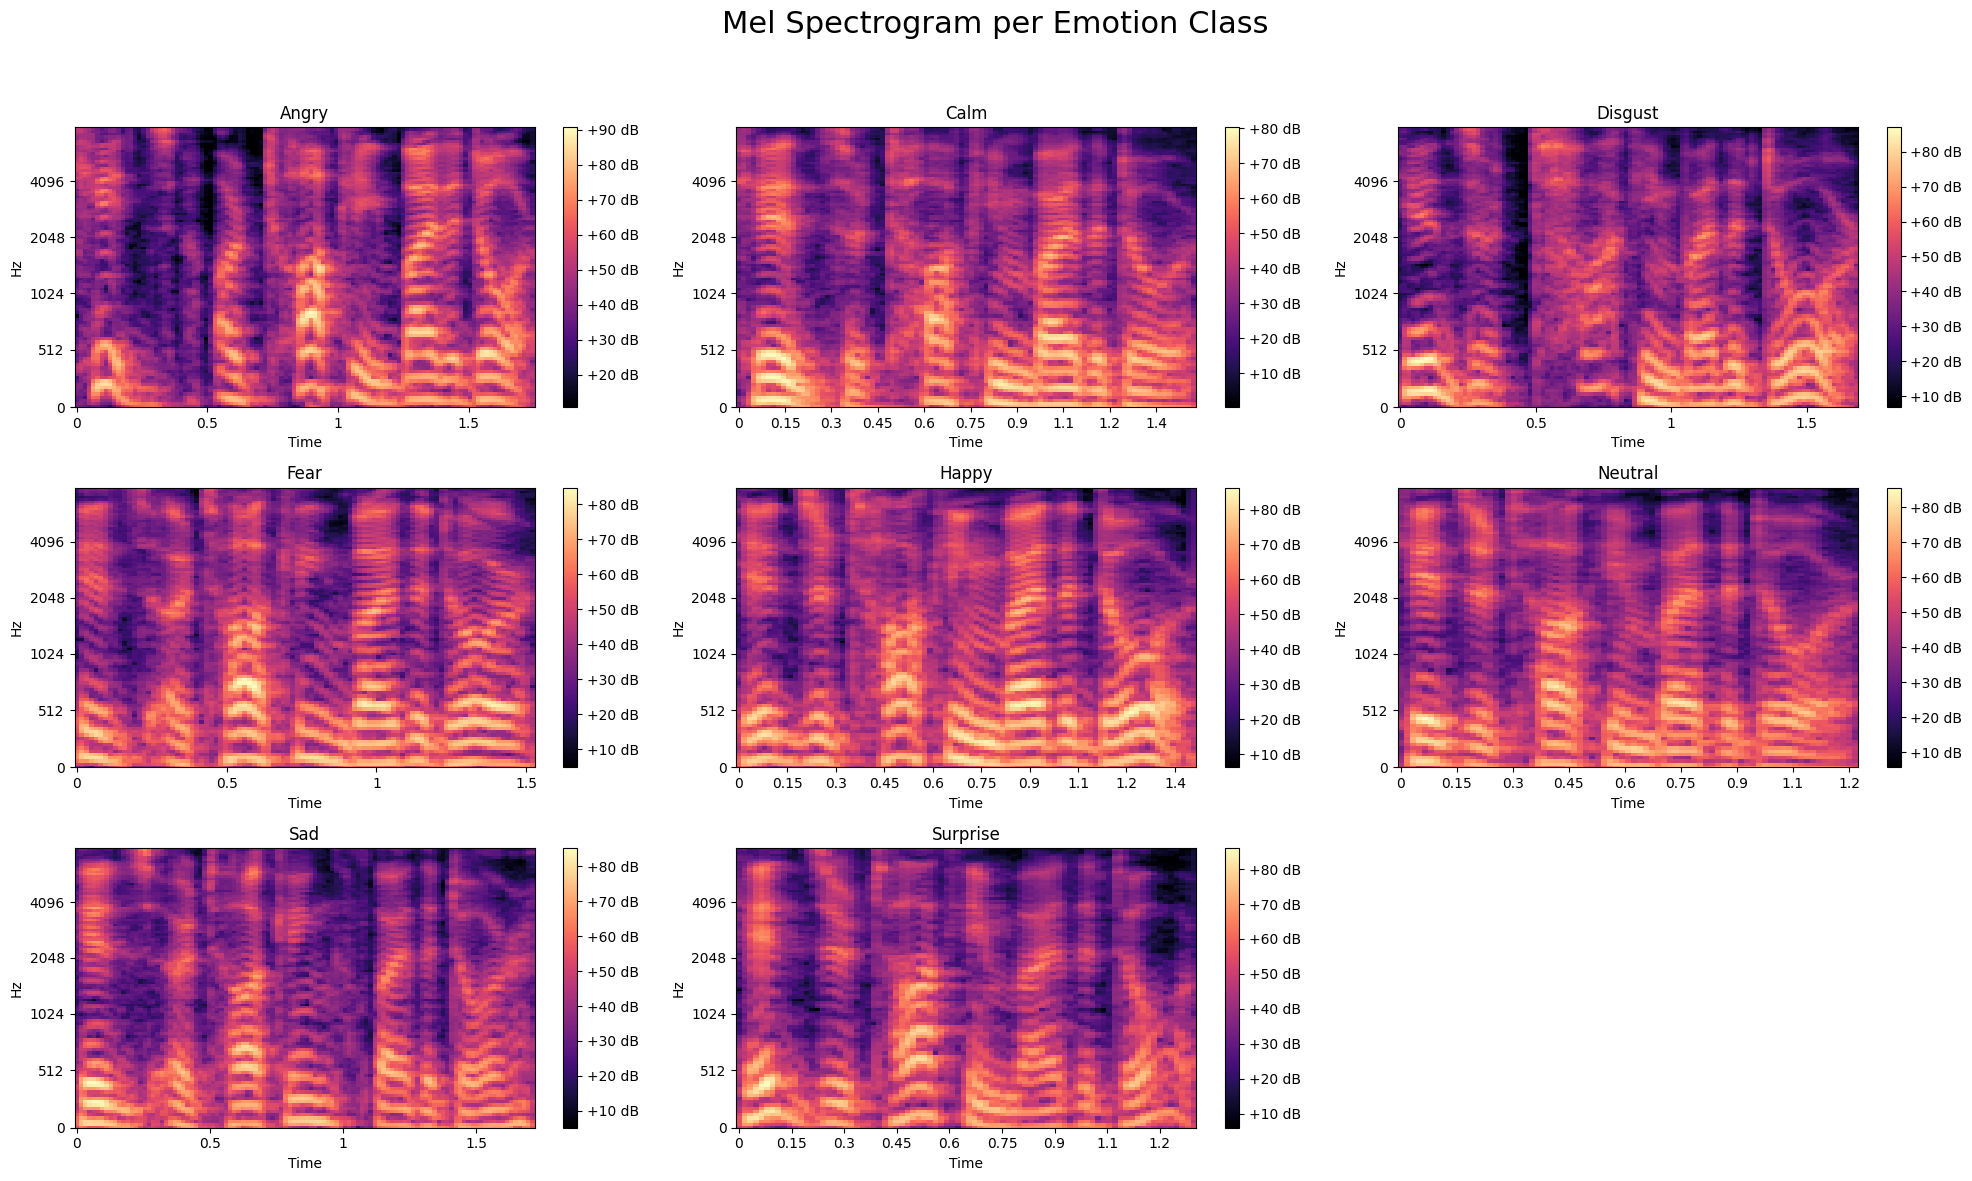

In [17]:
base_path = 'data/audio'
emotion_classes = sorted(os.listdir(base_path))

# Plot setup: Adjust rows/cols if needed
n_classes = len(emotion_classes)
cols = 3
rows = int(np.ceil(n_classes / cols))
plt.figure(figsize=(20, 4 * rows))

for i, emotion in enumerate(emotion_classes):
    emotion_path = os.path.join(base_path, emotion)
    wav_files = [f for f in os.listdir(emotion_path) if f.endswith('.wav')]
    if not wav_files:
        continue

    file_path = os.path.join(emotion_path, wav_files[0])
    spectrogram = preprocess_librosa(file_path)

    ax = plt.subplot(rows, cols, i + 1)
    img = librosa.display.specshow(spectrogram[:, :, 0], sr=32000, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(emotion.capitalize())
    plt.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set_ylim(0, 8000)

plt.suptitle('Mel Spectrogram per Emotion Class', fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

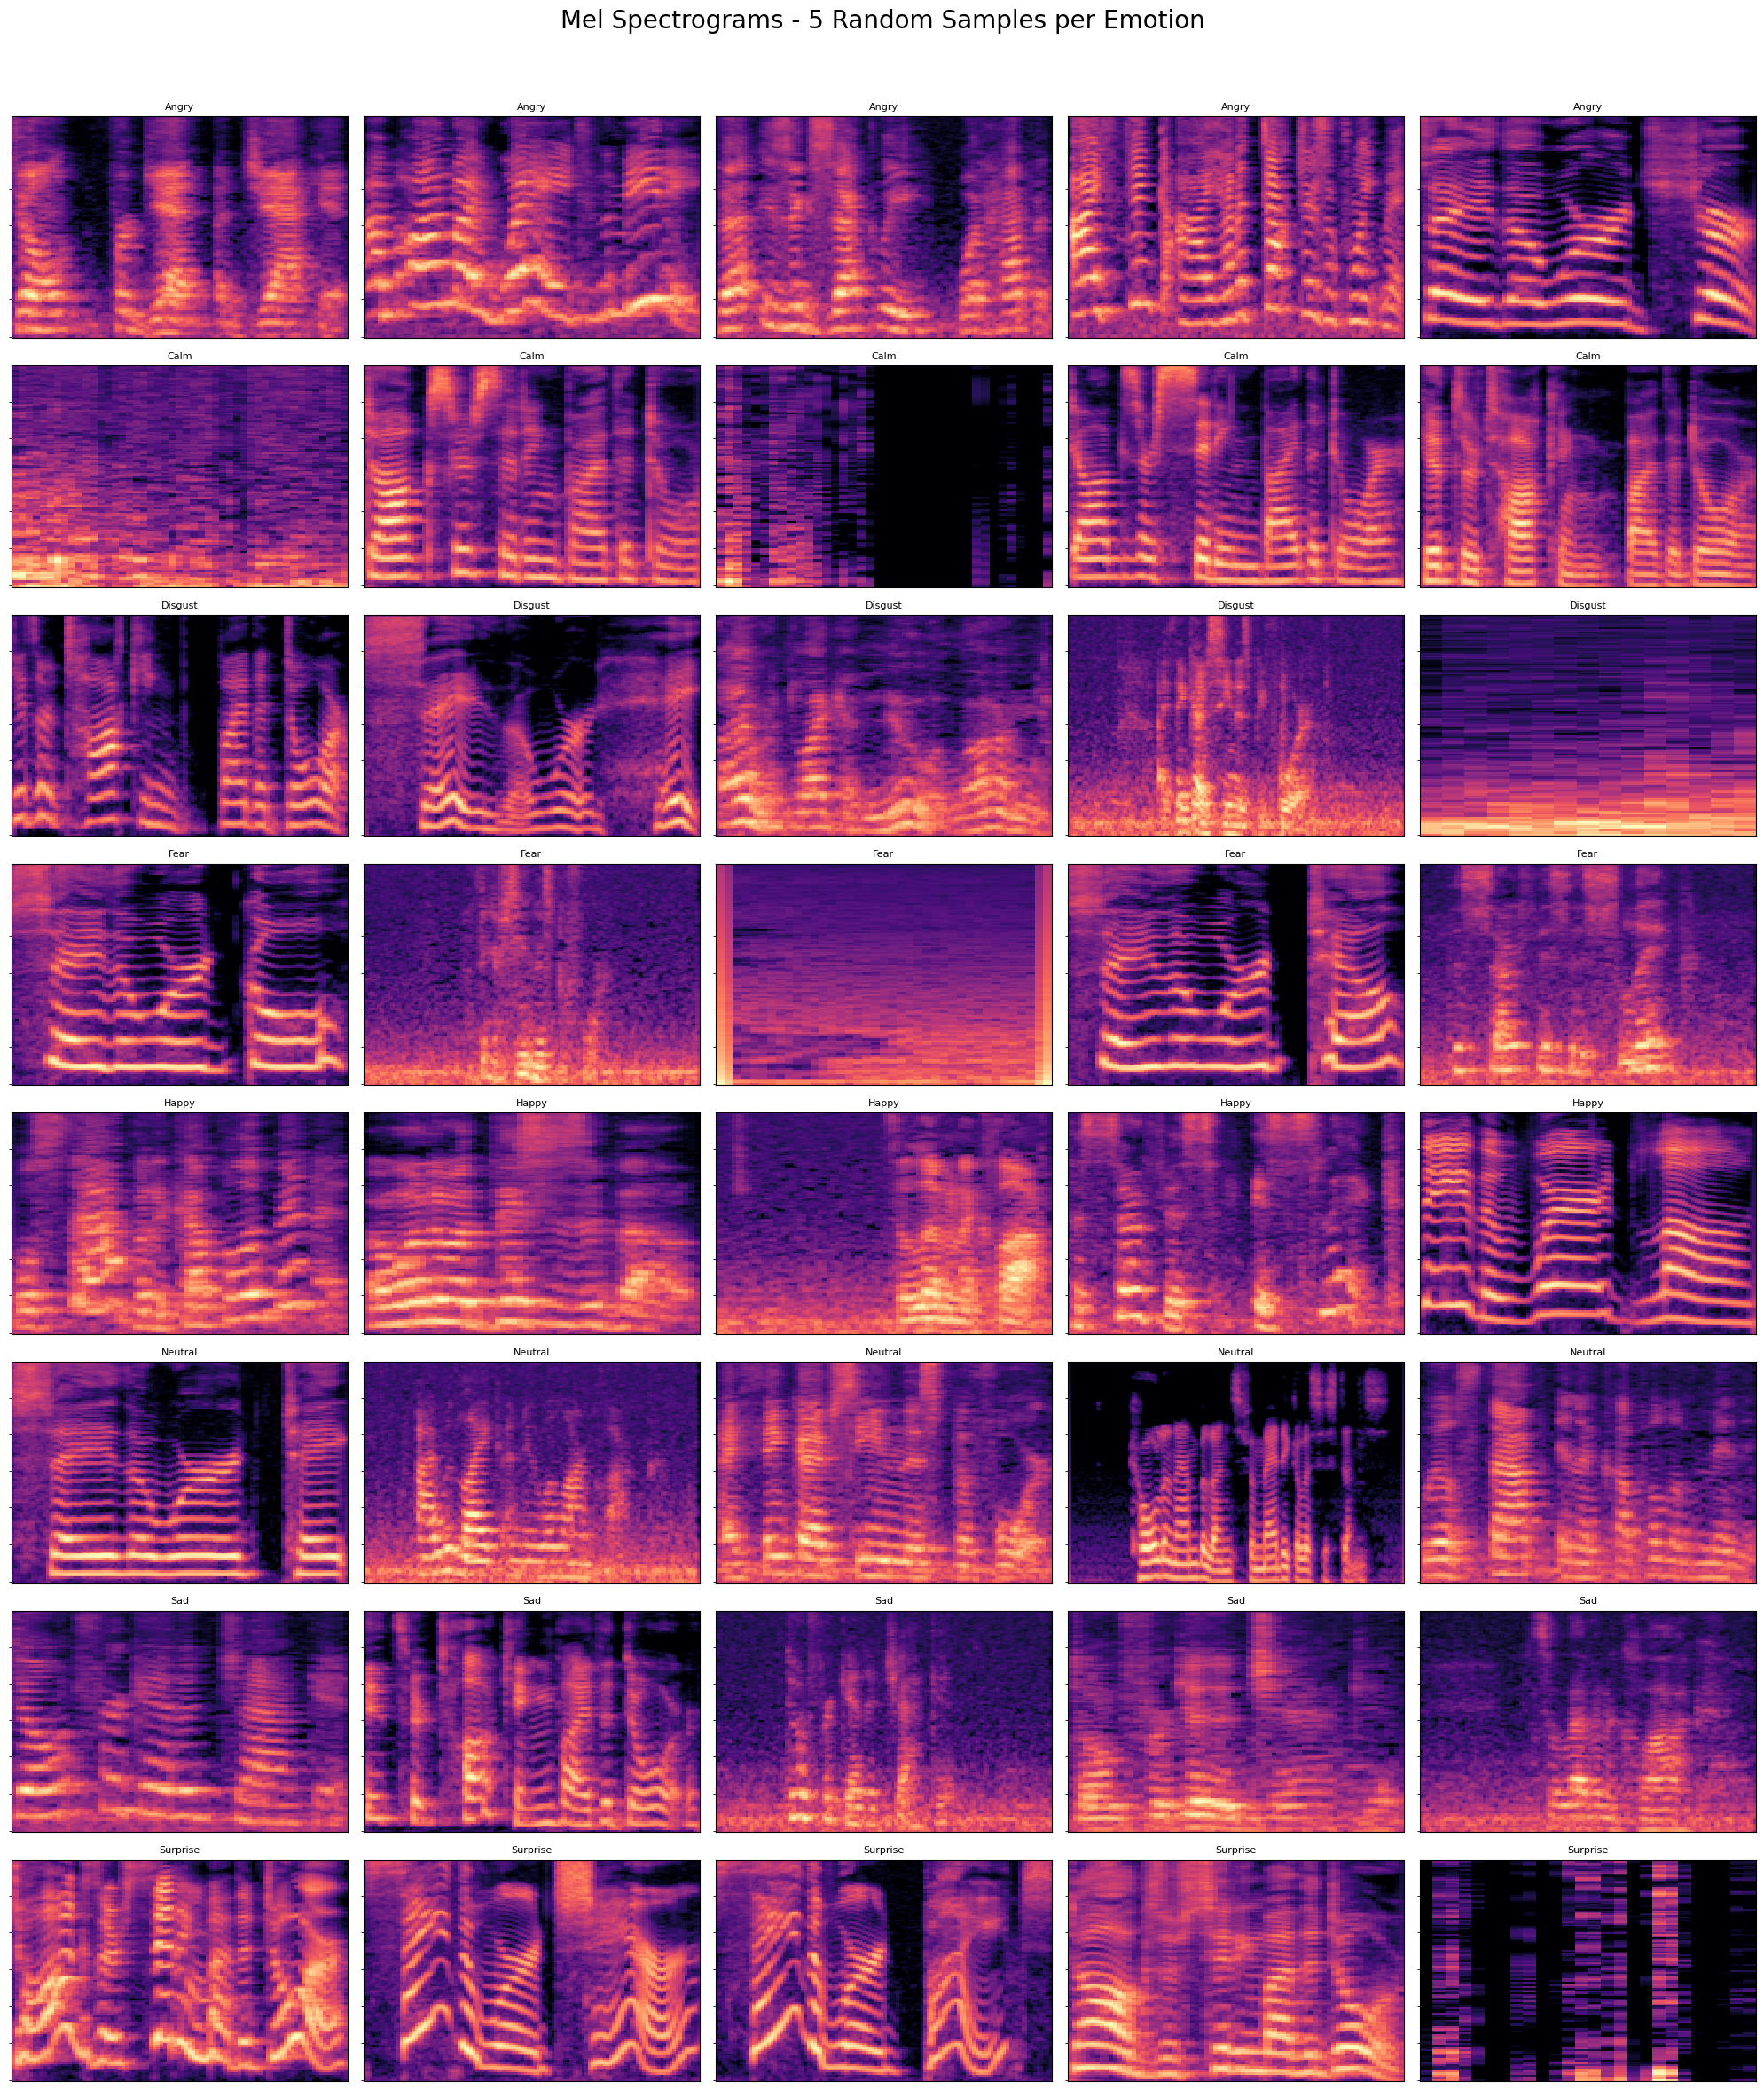

In [18]:
base_path = 'data/audio'
emotion_classes = sorted(os.listdir(base_path))
num_per_class = 5

cols = num_per_class
rows = len(emotion_classes)

plt.figure(figsize=(cols * 4, rows * 3))

plot_index = 1
for emotion in emotion_classes:
    emotion_path = os.path.join(base_path, emotion)
    wav_files = [f for f in os.listdir(emotion_path) if f.endswith('.wav')]
    if len(wav_files) < num_per_class:
        continue

    selected_files = random.sample(wav_files, num_per_class)

    for filename in selected_files:
        file_path = os.path.join(emotion_path, filename)
        spectrogram = preprocess_librosa(file_path)

        ax = plt.subplot(rows, cols, plot_index)
        img = librosa.display.specshow(
            spectrogram[:, :, 0],
            sr=32000,
            x_axis='time',
            y_axis='mel',
            cmap='magma',
            ax=ax
        )
        ax.set_title(emotion.capitalize(), fontsize=8)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        plot_index += 1

plt.suptitle('Mel Spectrograms - 5 Random Samples per Emotion', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [19]:
spec_shape = spectogram.shape
spectogram.shape

(128, 110, 3)

In [20]:
label = []
filepath = []
data = []

In [ ]:
for classes in os.listdir(base_path):
    for file in os.listdir(os.path.join(base_path, classes)):
        file_path = os.path.join(base_path, classes, file)
        spectrogram = preprocess_librosa(file_path)

        filepath.append(file_path)
        data.append(spectrogram)
        label.append(classes)


In [25]:
audio = pd.DataFrame({
    'filepath': filepath,
    'label': label,
    'data': data,
})

In [26]:
audio.head()

filepath  label  \
0  data/dataset_v2/audio\angry\03-01-05-01-01-01-...  angry   
1  data/dataset_v2/audio\angry\03-01-05-01-01-01-...  angry   
2  data/dataset_v2/audio\angry\03-01-05-01-01-01-...  angry   
3  data/dataset_v2/audio\angry\03-01-05-01-01-01-...  angry   
4  data/dataset_v2/audio\angry\03-01-05-01-01-01-...  angry   

                                                data  
0  [[[37.24952, 37.24952, 37.24952], [37.200745, ...  
1  [[[37.24952, 37.24952, 37.24952], [37.200745, ...  
2  [[[44.247833, 44.247833, 44.247833], [45.21157...  
3  [[[31.916271, 31.916271, 31.916271], [37.21556...  
4  [[[31.916271, 31.916271, 31.916271], [37.21556...

In [19]:
df_train, df_temp = train_test_split(audio, test_size=0.4, stratify=audio['label'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(audio['label'])

df_train['label_encoded'] = le.transform(df_train['label'])
df_val['label_encoded'] = le.transform(df_val['label'])
df_test['label_encoded'] = le.transform(df_test['label'])

num_classes = len(le.classes_)  # Keep for model output layer


In [ ]:
# def create_dataset(df):
#     x = np.array(df['data'].tolist(), dtype=np.float32)
#     y = np.array(df['label_encoded'].tolist(), dtype=np.int32)
#     dataset = tf.data.Dataset.from_tensor_slices((x, y))
#     return dataset
# 
# BATCH_SIZE = 32
# AUTOTUNE = tf.data.AUTOTUNE
# 
# train_ds = create_dataset(df_train).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
# val_ds = create_dataset(df_val).batch(BATCH_SIZE).prefetch(AUTOTUNE)
# test_ds = create_dataset(df_test).batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [9]:
test_image = "data/new_data/train/disgust/Training_659019.jpg"